In [2]:
import numpy as np
import glob
from keras.models import *
from keras.layers import *
import keras
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
datafiles, maskfiles = glob.glob("./Data/*.tiff"), glob.glob("./Mask/*.tiff")
files = np.array([t for t in zip(datafiles, maskfiles)], dtype=object)

In [4]:
def readimg(filelist):
    data, mask = list(), list()
    for d,m in filelist:
        data.append(cv2.imread(d))
        mask.append(cv2.imread(m, cv2.IMREAD_GRAYSCALE))
    mask = np.array(mask, dtype=float)/255.0
    mask = np.stack((1.0-mask, mask), axis=-1)
    return np.array(data, dtype=float)/255.0, mask

In [5]:
def generator(batchsize, flist):
    flist_ = np.copy(flist)
    while True:
        rnd = np.random.permutation(len(flist_))
        flist_ = flist_[rnd]
        batches = int(len(flist_)/batchsize)
        for i in range(batches):
            yield readimg(flist_[i*batchsize:(i+1)*batchsize])
    

In [25]:
# defining the model

input_shape=(300,400,3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(13,13), strides=(1,1), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(40, kernel_size=(11,11), strides=(2,2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(9,9), strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(192, kernel_size=(7,7), strides=(2,2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(192, kernel_size=(5,5), strides=(2,2), activation='relu',output_padding=(0,1)))
model.add(BatchNormalization())
model.add(Conv2DTranspose(96, kernel_size=(7,7), strides=(2,2), activation='relu', output_padding=(0,0)))
model.add(BatchNormalization())
model.add(Conv2DTranspose(40, kernel_size=(9,9), strides=(1,1), activation='relu', output_padding=(0,0)))
model.add(BatchNormalization())
model.add(Conv2DTranspose(32, kernel_size=(11,11), strides=(2,2), activation='relu', output_padding=(1,1)))
model.add(BatchNormalization())
model.add(Conv2DTranspose(2, kernel_size=(13,13), strides=(1,1), activation='softmax', output_padding=(0,0)))

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 288, 388, 32)      16256     
_________________________________________________________________
batch_normalization_37 (Batc (None, 288, 388, 32)      128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 139, 189, 40)      154920    
_________________________________________________________________
batch_normalization_38 (Batc (None, 139, 189, 40)      160       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 131, 181, 96)      311136    
_________________________________________________________________
batch_normalization_39 (Batc (None, 131, 181, 96)      384       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 63, 88, 192)       903360    
__________

(3, 300, 400, 2)


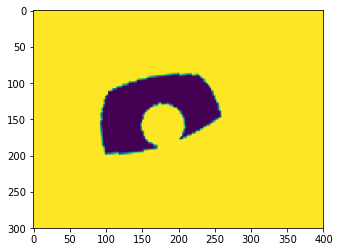

In [26]:
D_s, M_s = readimg(files[:3])
print(M_s.shape)
plt.imshow(M_s[0,:,:,0])
plt.show()

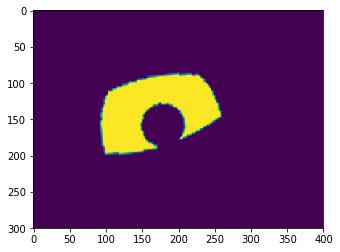

In [27]:
plt.imshow(M_s[0,:,:,1])
plt.show()
del D_s; del M_s;

In [28]:
# D, M = readimg(files[:500])

In [29]:
bs = 5
history = model.fit_generator(generator(bs,files),
                              steps_per_epoch=int(len(files)/bs),
                              epochs=3,
                              verbose=1,
                              validation_data=generator(bs, files),
                              validation_steps=1)
model.save('my_model.h5')

Epoch 1/3
2000/2000 [==============================] - 2475s 1s/step - loss: 0.2788 - acc: 0.8815 - val_loss: 0.3492 - val_acc: 0.8484
Epoch 2/3
2000/2000 [==============================] - 2464s 1s/step - loss: 0.1542 - acc: 0.9370 - val_loss: 0.2196 - val_acc: 0.9041
Epoch 3/3
2000/2000 [==============================] - 2468s 1s/step - loss: 0.1271 - acc: 0.9489 - val_loss: 0.1317 - val_acc: 0.9443


In [87]:
Dnew, Mnew = readimg(files[6100:6120])
Mnew_ = model.predict(Dnew)
# Mnew_ = np.floor(Mnew_*2.0)/2.0

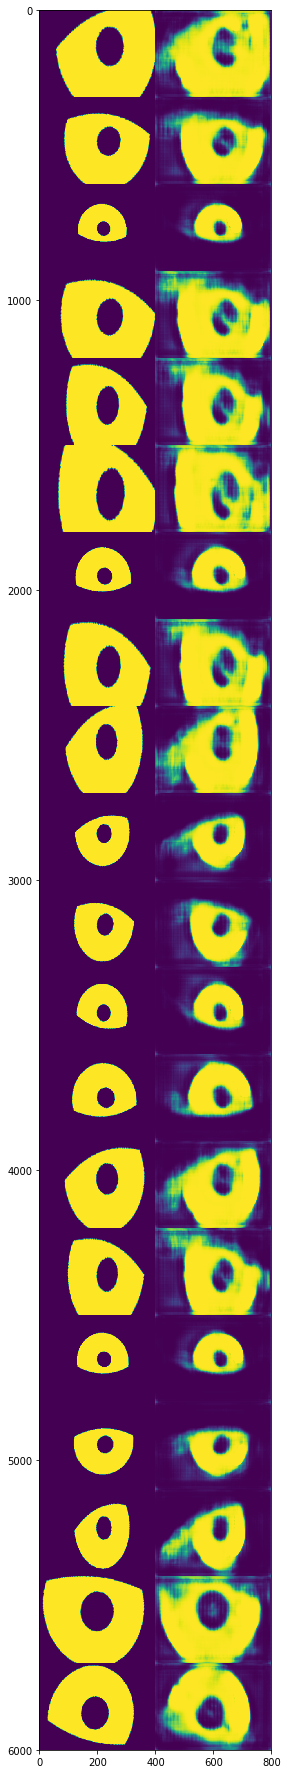

In [92]:
combined = np.zeros((300*len(Mnew),400*2), dtype=float)
for i in range(len(Mnew)):
    combined[300*i:300*(i+1),:400] = Mnew[i,:,:,1]
    combined[300*i:300*(i+1),400:] = Mnew_[i,:,:,1]
plt.figure(figsize=(32,32))
plt.imshow(combined)
plt.show()